In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import sklearn
import tqdm
from tqdm import tqdm
import nltk
import warnings
warnings.filterwarnings("ignore") 
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [3]:
os.chdir("/content/drive/My Drive/Self Case Study 2") 

Check how many images are there and how many report files are there

In [ ]:
print("there are {} number of reports in the data ".format(len(os.listdir("ecgen-radiology"))))
print("there are {} number of x-rays in the data ".format(len(os.listdir("NLMCXR_png")))) 

there are 3955 number of reports in the data 
there are 7472 number of x-rays in the data 


There are more number of images than the number of essays. This is because a report can be associated with one or more x-rays. A person can have x-rays taken from more than one views. But the medical report for all these x-rays are same only.

### Extracting the medical reports from the xml file

The medical reports are available in the form of xml files. Inside each xml file a lot of data are present other than the actual report. We need to extract the medical statement of each x-ray from these xml files. Also, we need to find the x-rays corresponding to these medical reports for proper training to be done. The image ids are also available in the xml files

In [ ]:
from google.colab import files
files=files.upload()

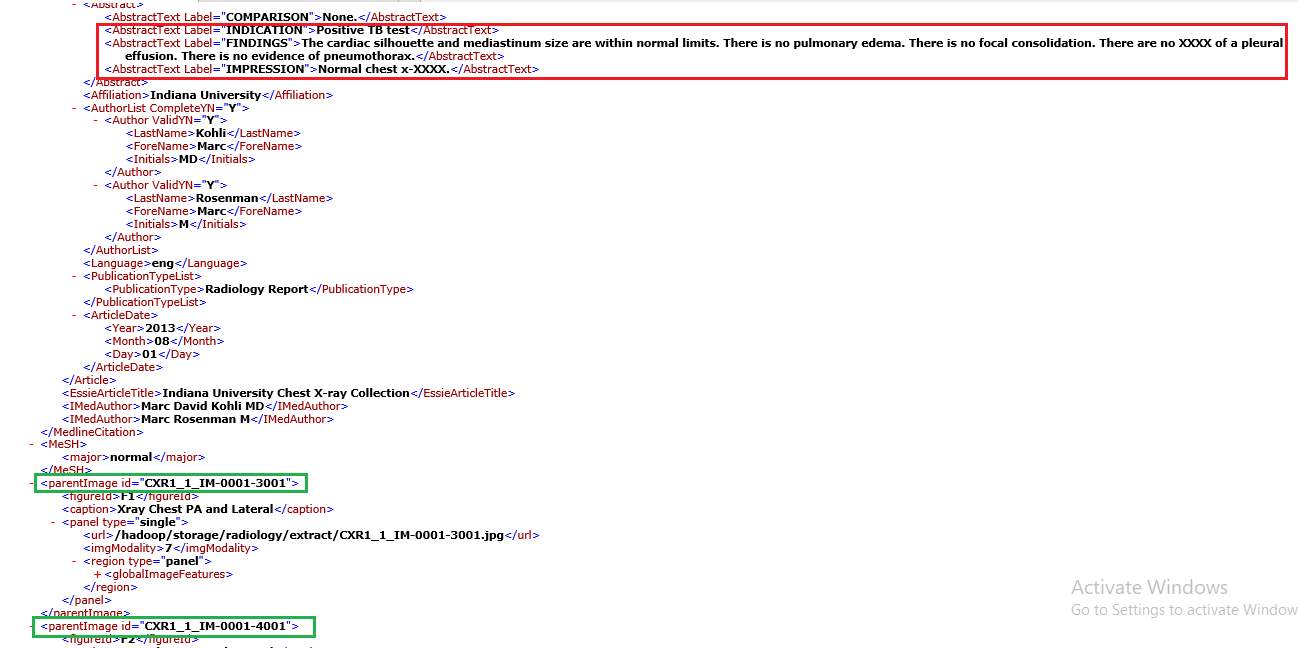

In [ ]:
from IPython.display import Image
Image("report sample.PNG", width=1000, height=800)

We need to extract the findngs, impression, and indication from these xml files as reports. Also we need to extract the image ids to get the x-ray corresponding to that report

In [4]:
#https://www.geeksforgeeks.org/xml-parsing-python/

import xml.etree.ElementTree as et
id=[]
finding=[]
count=[]
indication=[]
impression=[]

for report in tqdm(os.listdir("ecgen-radiology")):
  #create element tree object
  tree=et.parse("ecgen-radiology/"+report)
  #get the root element
  root=tree.getroot()
  #inside the root element
  for child in root:
      if child.tag == "MedlineCitation":
          for each in child:
              if each.tag == "Article":
                  for i in each:
                      if i.tag == "Abstract":
                          for j in i:

                            if j.get('Label')=='INDICATION':
                              indic=j.text
                              
                            if j.get("Label") == "FINDINGS":
                              find = j.text
                                
                            if j.get('Label')=='IMPRESSION':
                              
                              impr=j.text
                              
                                       
  image_count=0 #this is to find the number of x-rays in each report 
  for img_id in root.findall("parentImage"):
    id.append(img_id.get("id")+".png")
    finding.append(find)
    impression.append(impr)
    indication.append(indic)
    image_count+=1
  count.append(image_count)  

100%|██████████| 3955/3955 [14:54<00:00,  4.42it/s]


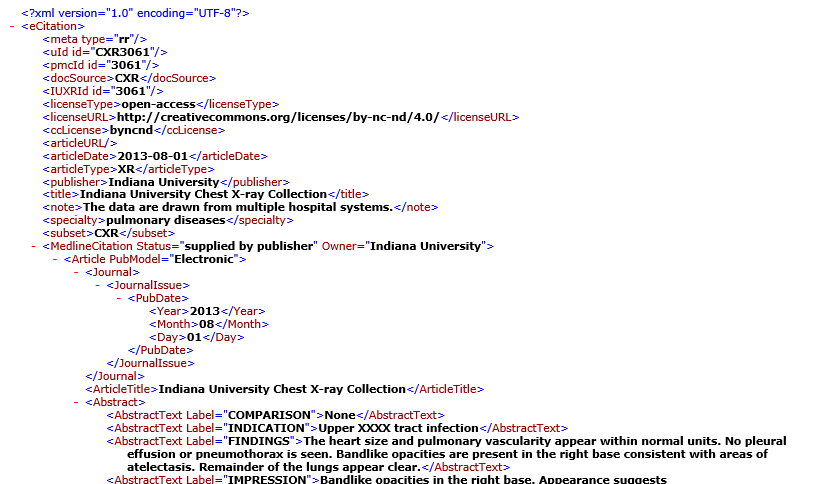

In [ ]:
from IPython.display import Image
Image("reprt 2.PNG", width=1000, height=800) 

In [5]:
df=pd.DataFrame()
patient_id=[i[:-9] for i in id]
df["patient_id"]=patient_id
df["image_id"]=["NLMCXR_png/"+ i for i in id]
df["finding"]=finding
df["impression"]=impression
df["indication"]=indication

print(df.shape)
df

(7470, 5)


,patient_id,image_id,finding,impression,indication
0,CXR3676_IM-1829-0001,NLMCXR_png/CXR3676_IM-1829-0001-0001.png,The cardiomediastinal silhouette appears irreg...,1. Redemonstration of diffuse bilateral pulmon...,XXXX-year-old male with XXXX.
1,CXR3676_IM-1829-0001,NLMCXR_png/CXR3676_IM-1829-0001-0002.png,The cardiomediastinal silhouette appears irreg...,1. Redemonstration of diffuse bilateral pulmon...,XXXX-year-old male with XXXX.
2,CXR3660_IM-1820,NLMCXR_png/CXR3660_IM-1820-1001.png,"Lungs are clear without focal consolidation, e...",Negative for acute cardiopulmonary abnormality.,XXXX-year-old male with XXXX and COPD
3,CXR3660_IM-1820,NLMCXR_png/CXR3660_IM-1820-2001.png,"Lungs are clear without focal consolidation, e...",Negative for acute cardiopulmonary abnormality.,XXXX-year-old male with XXXX and COPD
4,CXR37_IM-1847-0001,NLMCXR_png/CXR37_IM-1847-0001-0001.png,The heart is normal in size. The mediastinum i...,No acute disease.,HYPOXIA;
...,...,...,...,...,...
7465,CXR1850_IM-0552,NLMCXR_png/CXR1850_IM-0552-2001.png,"The lungs are clear bilaterally. Specifically,...",No acute cardiopulmonary abnormality..,XXXX-year-old XXXX with chest pain and shortne...
7466,CXR1857_IM-0556,NLMCXR_png/CXR1857_IM-0556-1001.png,Mild cardiomegaly. Normal size and mediastinal...,Mild cardiomegaly. Clear lungs. .,Syncope.
7467,CXR1857_IM-0556,NLMCXR_png/CXR1857_IM-0556-4004.png,Mild cardiomegaly. Normal size and mediastinal...,Mild cardiomegaly. Clear lungs. .,Syncope.
7468,CXR1879_IM-0569,NLMCXR_png/CXR1879_IM-0569-1001.png,Heart size within normal limits. No focal airs...,No acute cardiopulmonary findings. Specificall...,XXXX-year-old female with tuberculosis contact...


In [6]:
#check the lengths of reports
length=[]
for report in df["finding"]:
  try:
    length.append(len(report.split()))
  except:
    pass
length=np.array(length)
print("the mean lengths of reports is ",np.mean(length))
print("the 80th percentile lengths of reports is ",np.percentile(length,80))
print("the 90th percentile lengths of reports is ",np.percentile(length,90))
print("the 99th percentile lengths of reports is ",np.percentile(length,99))
print("the maximum value of lengths of reports is ",np.max(length))

the mean lengths of reports is  31.32164375096555
the 80th percentile lengths of reports is  41.0
the 90th percentile lengths of reports is  50.0
the 99th percentile lengths of reports is  79.0
the maximum value of lengths of reports is  169


Most of the reports have a length less than 80

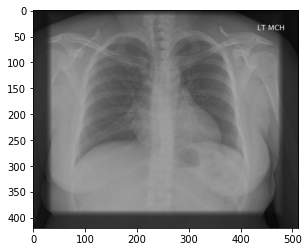

FINDINGS: The heart is normal in size. The pulmonary vascularity is within normal limits in appearance. No focal air space opacities. No pleural effusions or pneumothorax. No acute bony abnormalities.
IMPRESSION: No acute cardiopulmonary abnormalities.
INDICATION: Dyspnea.
****************************************************************************************************


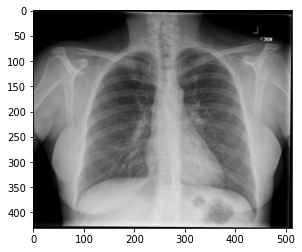

FINDINGS: Lungs are clear bilaterally. Cardiac and mediastinal silhouettes are normal. Pulmonary vasculature is normal. No pneumothorax or pleural effusion. No acute bony abnormality.
IMPRESSION: No acute cardiopulmonary abnormality.
INDICATION: Shortness of breath, wheezing, XXXX.
****************************************************************************************************


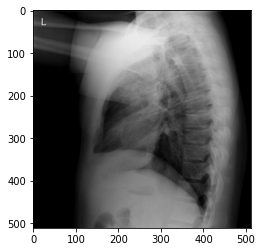

FINDINGS: Cardiomediastinal silhouette is within normal limits. No focal consolidation. No pneumothorax or pleural effusion. No acute bony abnormalities.
IMPRESSION: No acute cardiopulmonary abnormalities. .
INDICATION: XXXX-year-old male with XXXX, shortness breath, and asthma.
****************************************************************************************************


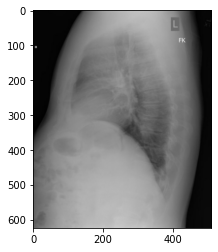

FINDINGS: Low lung volumes are present. The heart size and pulmonary vascularity appear within normal limits. The lungs are free of focal airspace disease. No pleural effusion or pneumothorax is seen. Mild degenerative changes are present in the spine.
IMPRESSION: 1. No evidence of active disease.
INDICATION: XXXX, wheezing, XXXX.
****************************************************************************************************


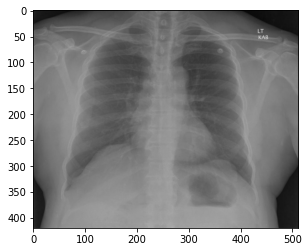

FINDINGS: The lungs are clear. The cardiomediastinal silhouette is within normal limits. No pleural effusion is identified.
IMPRESSION: Normal chest film.
INDICATION: Palpitations
****************************************************************************************************


In [ ]:
#print some sample x-rays and findings
a=np.random.choice(range(7470),5)
for each in a:
  img=cv2.imread(df.iloc[each]["image_id"])
  plt.imshow(img)
  plt.show()
  print("FINDINGS:",df.iloc[each]["finding"])
  print("IMPRESSION:",df.iloc[each]["impression"])
  print("INDICATION:",df.iloc[each]["indication"])
  print("*"*100)

There are frontal and lateral views of x-rays.

From this dataframe we can see that the observations are written as findings and impressions. So we take the findings as the report. For that, we need to make sure that every report has findings

In [ ]:
#finding the number of reports were findings is none
none=sum(df["finding"].isnull().values.ravel())
print("there are {} number of records where finding is none".format(none))

there are 997 number of records where finding is none


So if the findings is none for a particular record, we use the corresponding impression as findings to that record

In [ ]:

for i in range(df.shape[0]):
  if finding[i] is None:
    
    finding[i]=impression[i]
    

df["finding"]=finding

In [ ]:
none=sum(df["finding"].isnull().values.ravel())
print("there are {} number of records where finding is none".format(none))


there are 40 number of records where finding is none


Still there are 40 reports without any findings. This is because these reports doesnot have the impression data as well. We need to drop these rows

From the indication data, we don't get much useful medical reports. So we drop the impression and indication columns and keep only the patient id, image id and the findings. We drop all the rows without findings

In [ ]:
df=df.dropna()
none=sum(df["finding"].isnull().values.ravel())
print("there are {} number of records where finding is none".format(none))
df=df.drop(["impression","indication"],axis=1)

there are 0 number of records where finding is none


In [ ]:
df

,patient_id,image_id,finding
0,CXR3676_IM-1829-0001,NLMCXR_png/CXR3676_IM-1829-0001-0001.png,The cardiomediastinal silhouette appears irreg...
1,CXR3676_IM-1829-0001,NLMCXR_png/CXR3676_IM-1829-0001-0002.png,The cardiomediastinal silhouette appears irreg...
2,CXR3660_IM-1820,NLMCXR_png/CXR3660_IM-1820-1001.png,"Lungs are clear without focal consolidation, e..."
3,CXR3660_IM-1820,NLMCXR_png/CXR3660_IM-1820-2001.png,"Lungs are clear without focal consolidation, e..."
4,CXR37_IM-1847-0001,NLMCXR_png/CXR37_IM-1847-0001-0001.png,The heart is normal in size. The mediastinum i...
...,...,...,...
7465,CXR1850_IM-0552,NLMCXR_png/CXR1850_IM-0552-2001.png,"The lungs are clear bilaterally. Specifically,..."
7466,CXR1857_IM-0556,NLMCXR_png/CXR1857_IM-0556-1001.png,Mild cardiomegaly. Normal size and mediastinal...
7467,CXR1857_IM-0556,NLMCXR_png/CXR1857_IM-0556-4004.png,Mild cardiomegaly. Normal size and mediastinal...
7468,CXR1879_IM-0569,NLMCXR_png/CXR1879_IM-0569-1001.png,Heart size within normal limits. No focal airs...


Now, from this dataframe, we can see that, in some cases there are more than one image associated with a patient. So we check the number of images or x-rays per patient

Text(0.5, 1.0, 'number of image per patient ')

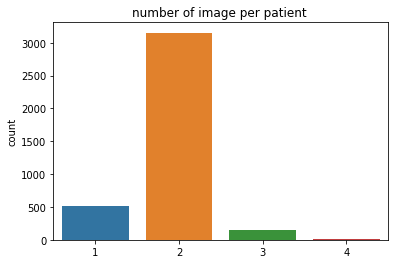

In [ ]:
d=dict()
for patient in df["patient_id"]:
  if patient in d:
    d[patient]+=1
  else:
    d[patient]=1

count=list(d.values())
sns.countplot(count)
plt.title("number of image per patient ")

Most of the reports have two x-ray images associated with it. Some patients have 1 image assocaited with their report. Most of the patients have 2 images of x-ray. Some has 3 or 4 x-ray images

Let's analyse the x-rays of patients who has more than 3 x-rays

In [ ]:
#https://www.geeksforgeeks.org/xml-parsing-python/

import xml.etree.ElementTree as et
img=[]

for report in tqdm(os.listdir("ecgen-radiology")):
  #create element tree object
  tree=et.parse("ecgen-radiology/"+report)
  
  root=tree.getroot()
  
  
  if len(root.findall("parentImage"))>3:
    for img_id in root.findall("parentImage"):
    
      img.append(img_id.get("id")+".png")
  
    break


  5%|▍         | 197/3955 [00:00<00:05, 751.11it/s]


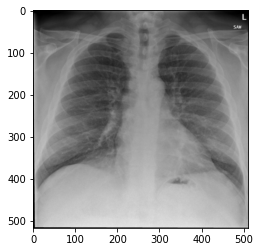

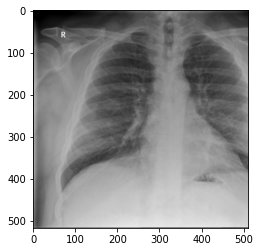

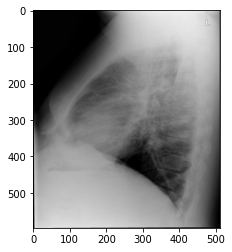

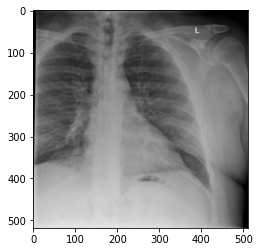

In [ ]:
for i in img:
  image=cv2.imread("NLMCXR_png/"+i)
  plt.imshow(image)
  plt.show()

We consider two images for every patient since most of the patients has two images. If there are more than two images per patient, we randomly select two from the images. If there is only one image associated with a patient, then we duplicate the image

In [ ]:
d=dict() #where key is the patient id and value is the images
d1=dict() # where key is the patient id and value is the report or findings
for row in range(df.shape[0]):
  if df.iloc[row]["patient_id"] in d:
    d[df.iloc[row]["patient_id"]].append(df.iloc[row]["image_id"])
  else:
    d[df.iloc[row]["patient_id"]]=[df.iloc[row]["image_id"]]

  d1[df.iloc[row]["patient_id"]]=[df.iloc[row]["finding"]]

In [ ]:
#images and findings associated with the first patient
print(d["CXR3676_IM-1829-0001"])
print(d1["CXR3676_IM-1829-0001"])

['NLMCXR_png/CXR3676_IM-1829-0001-0001.png', 'NLMCXR_png/CXR3676_IM-1829-0001-0002.png']
["The cardiomediastinal silhouette appears irregular secondary to the diffuse bilateral pulmonary interstitial disease. The thoracic aorta is tortuous. Calcified lymph XXXX are demonstrated in the left hilum. No focal pulmonary consolidation. Diffuse increased bilateral pulmonary interstitial markings, consistent with the patient's history of known pulmonary fibrosis, with relative sparing of the bilateral lung apices. No pneumothorax or pleural effusion demonstrated. The thoracic spine appears intact."]


In [ ]:
image1=[]
image2=[]
report=[]
patient_id=[]
for patient in d.keys():

  #if there is only one image for a person
  if len(d[patient])==1:
    img1=d[patient][0]
    img2=d[patient][0]

  #if there are two images for a person
  elif len(d[patient])==2:
    img1=d[patient][0]
    img2=d[patient][1]
  
  #if there are three images for a person
  elif len(d[patient])==3:
    a=np.random.choice([0,1,2],2)
    img1=d[patient][a[0]]
    img2=d[patient][a[1]]

  #if there are four images for a person
  elif len(d[patient])==4:
    a=np.random.choice([0,1,2,3],2)
    img1=d[patient][a[0]]
    img2=d[patient][a[1]]
    
  image1.append(img1)
  image2.append(img2)
  report.append(d1[patient][0])
  patient_id.append(patient)

In [ ]:
df_dash=pd.DataFrame()
df_dash["patient_id"]=patient_id
df_dash["image1"]=image1
df_dash["image2"]=image2
df_dash["report"]=report
df_dash

,patient_id,image1,image2,report
0,CXR3676_IM-1829-0001,NLMCXR_png/CXR3676_IM-1829-0001-0001.png,NLMCXR_png/CXR3676_IM-1829-0001-0002.png,The cardiomediastinal silhouette appears irreg...
1,CXR3660_IM-1820,NLMCXR_png/CXR3660_IM-1820-1001.png,NLMCXR_png/CXR3660_IM-1820-2001.png,"Lungs are clear without focal consolidation, e..."
2,CXR37_IM-1847-0001,NLMCXR_png/CXR37_IM-1847-0001-0001.png,NLMCXR_png/CXR37_IM-1847-0001-0002.png,The heart is normal in size. The mediastinum i...
3,CXR366_IM-1820,NLMCXR_png/CXR366_IM-1820-1001.png,NLMCXR_png/CXR366_IM-1820-2001.png,The heart is normal in size. The mediastinum i...
4,CXR3696_IM-1846,NLMCXR_png/CXR3696_IM-1846-1001.png,NLMCXR_png/CXR3696_IM-1846-1002.png,Heart size is normal and lungs are clear. Stab...
...,...,...,...,...
3815,CXR1861_IM-0558,NLMCXR_png/CXR1861_IM-0558-1001.png,NLMCXR_png/CXR1861_IM-0558-2001.png,Normal cardiomediastinal silhouette. There is ...
3816,CXR1880_IM-0569,NLMCXR_png/CXR1880_IM-0569-1001.png,NLMCXR_png/CXR1880_IM-0569-1001.png,"The heart, pulmonary XXXX and mediastinum are ..."
3817,CXR1850_IM-0552,NLMCXR_png/CXR1850_IM-0552-2001.png,NLMCXR_png/CXR1850_IM-0552-2001.png,"The lungs are clear bilaterally. Specifically,..."
3818,CXR1857_IM-0556,NLMCXR_png/CXR1857_IM-0556-1001.png,NLMCXR_png/CXR1857_IM-0556-4004.png,Mild cardiomegaly. Normal size and mediastinal...


Now, we created a dataframe with two images per patient and the corresponding report as the finding

### Preprocess the text data

In [ ]:
# some sample report
print(df_dash["report"].values[:10])

["The cardiomediastinal silhouette appears irregular secondary to the diffuse bilateral pulmonary interstitial disease. The thoracic aorta is tortuous. Calcified lymph XXXX are demonstrated in the left hilum. No focal pulmonary consolidation. Diffuse increased bilateral pulmonary interstitial markings, consistent with the patient's history of known pulmonary fibrosis, with relative sparing of the bilateral lung apices. No pneumothorax or pleural effusion demonstrated. The thoracic spine appears intact."
 'Lungs are clear without focal consolidation, effusion, or pneumothorax. Normal heart size. Bony thorax and soft tissue is unremarkable.'
 'The heart is normal in size. The mediastinum is unremarkable. XXXX XXXX opacities in right mid lung. The lungs are otherwise grossly clear.'
 'The heart is normal in size. The mediastinum is unremarkable. The lungs are clear.'
 'Heart size is normal and lungs are clear. Stable 5 mm right midlung perform granuloma'
 'Normal heart size mediastinal co

In [ ]:
#convert into lowercase
finding=df_dash["report"].values
for idx in tqdm(range(len(finding))):
    
    lower=finding[idx].lower()
    finding[idx]=lower
  
df_dash["report"]=finding


100%|██████████| 3820/3820 [00:00<00:00, 616216.35it/s]


In [ ]:
#Now we need to expand the contractions like won't, can't, don't etc.
#https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"i'd": "i had / i would",
"i'd've": "i would have",
"i'll": "i shall / I will",
"i'll've": "i shall have / i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}



finding=df_dash["report"].values
for idx in tqdm(range(len(finding))):
  list_of_words=finding[idx].split(" ")
  
  sentence=""
  for i in list_of_words:
    
    if len(i)>2:
      
      if i in list(contractions.keys()):
        wrd=contractions[i]
      else:
        wrd=i
      
      sentence+=wrd+" "
    else:
      continue
  finding[idx]=sentence


100%|██████████| 3820/3820 [00:00<00:00, 12301.09it/s]


In [ ]:
'''Now we remove all the special characters, and digits from the report. also remove the extra spaces in the sentence. Also there
are some words like xxx. These words are not giving any additional meaning to the report. So we remove those words
'''

for idx in tqdm(range(len(finding))):
    
  report=re.sub("[^a-z.]"," ",finding[idx])
  report=re.sub("xx+","",report)
  report=re.sub(r'\b\w{1,2}\b',"",report) #some unwanted words came up which are having lenbth<2. They are also removed
  report=re.sub("\s\s+"," ",report)
  finding[idx]=report 
print("\n")


100%|██████████| 3820/3820 [00:00<00:00, 39202.65it/s]

In [ ]:
for i in finding[:10]:
  print(i)

  

the cardiomediastinal silhouette appears irregular secondary the diffuse bilateral pulmonary interstitial disease. the thoracic aorta tortuous. calcified lymph are demonstrated the left hilum. focal pulmonary consolidation. diffuse increased bilateral pulmonary interstitial markings consistent with the patient history known pulmonary fibrosis with relative sparing the bilateral lung apices. pneumothorax pleural effusion demonstrated. the thoracic spine appears intact. 
lungs are clear without focal consolidation effusion pneumothorax. normal heart size. bony thorax and soft tissue unremarkable. 
the heart normal size. the mediastinum unremarkable. opacities right mid lung. the lungs are otherwise grossly clear. 
the heart normal size. the mediastinum unremarkable. the lungs are clear. 
heart size normal and lungs are clear. stable right midlung perform granuloma 
normal heart size mediastinal contours. focal airspace consolidation. pleural effusion pneumothorax. degenerative disc disea

In [ ]:
df_dash["report"]=finding
df_dash.to_csv("data.csv")